In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
import umap.umap_ as umap 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE



2022-12-02 10:52:18.251891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
path = "data/"

data=pd.read_csv(path+'A2_data.csv')
X,y= data.loc[:, data.columns != 'class'], data['class']

print(f'There are {X.shape[0]} samples of each {X.shape[1]} features')

#Data includes some identifiers lets remove those 
ID_parameters= ['field_ID','MJD','plate']
for ID in ID_parameters:
    X=X.loc[:, X.columns != ID]


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

print(f'There are {X_train.shape[0]} training samples of each {X_train.shape[1]} features')

There are 67000 training samples of each 8 features


In [53]:
np.where(X['g']<0)

(array([79543]),)

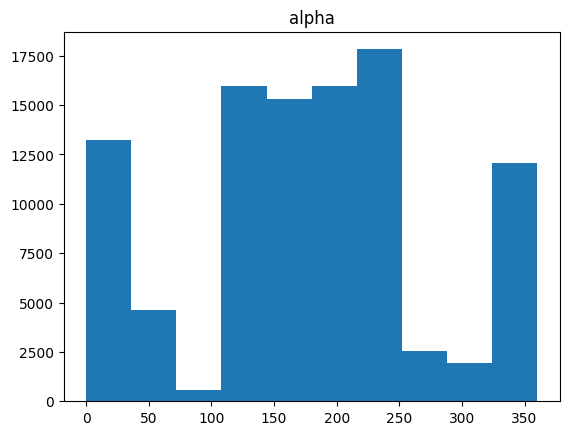

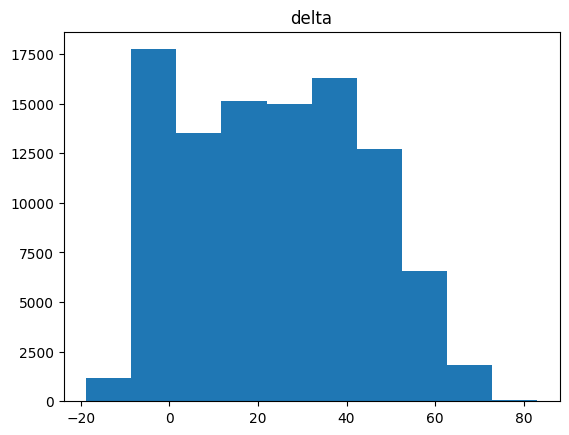

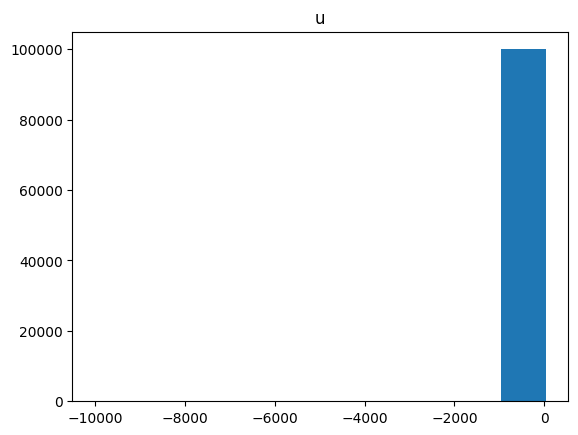

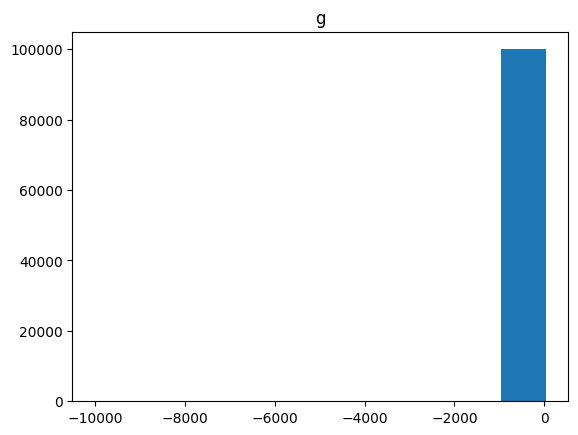

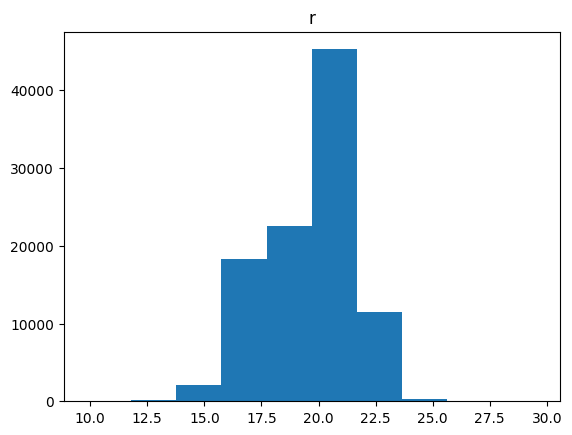

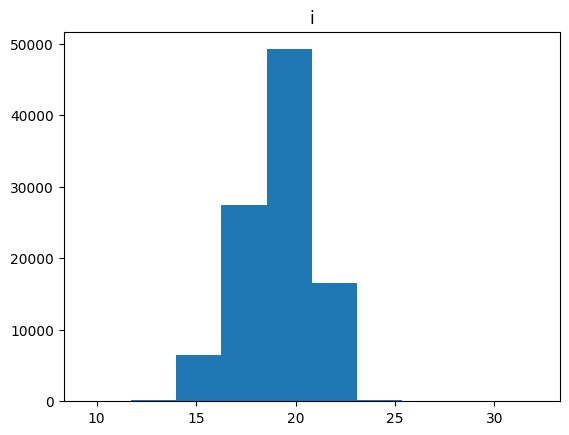

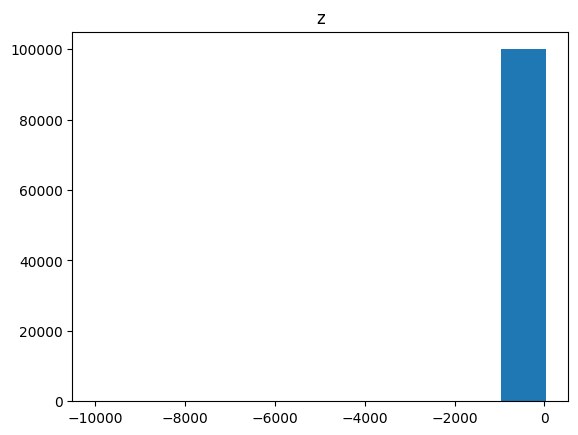

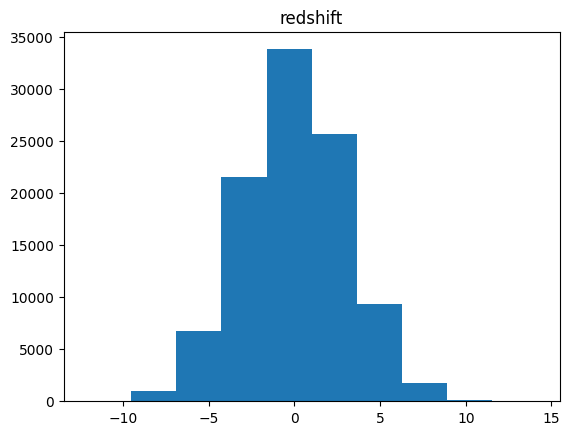

In [46]:
for C in X.columns:
    plt.hist(X[C])
    plt.title(C)
    plt.show()

In [34]:
#Visualise the models
def visualise_components(model_name, y, finaldim):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Component 1', fontsize = 15)
    ax.set_ylabel('Component 2', fontsize = 15)
    ax.set_title(f'2 component {model_name}', fontsize = 20)
    targets = np.unique(y)
    colors = ['r', 'g', 'b','k','y']
    for target, color in zip(targets,colors):
        indicesToKeep = finaldim['class'] == target
        ax.scatter(finaldim.loc[indicesToKeep, 'component 1']
                , finaldim.loc[indicesToKeep, 'component 2']
                , c = color
                , s = 50
                , marker = '.')
    ax.legend(targets, fontsize=15)
    ax.grid()
    plt.savefig(f'plots/{model_name}.pdf')
    plt.show()

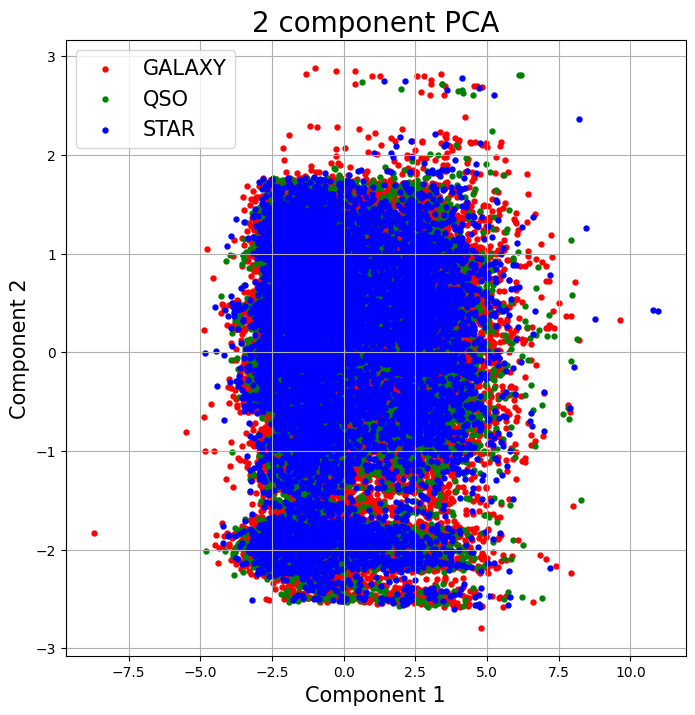

In [39]:
x = X_train
x = StandardScaler().fit_transform(x)


# Use PCA to reduce to two dimensions
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principal = pd.DataFrame(data = principalComponents,columns = ['component 1', 'component 2'])
finalPca = pd.concat([principal, y_train], axis = 1)
finalPca

visualise_components('PCA', y_train, finalPca)


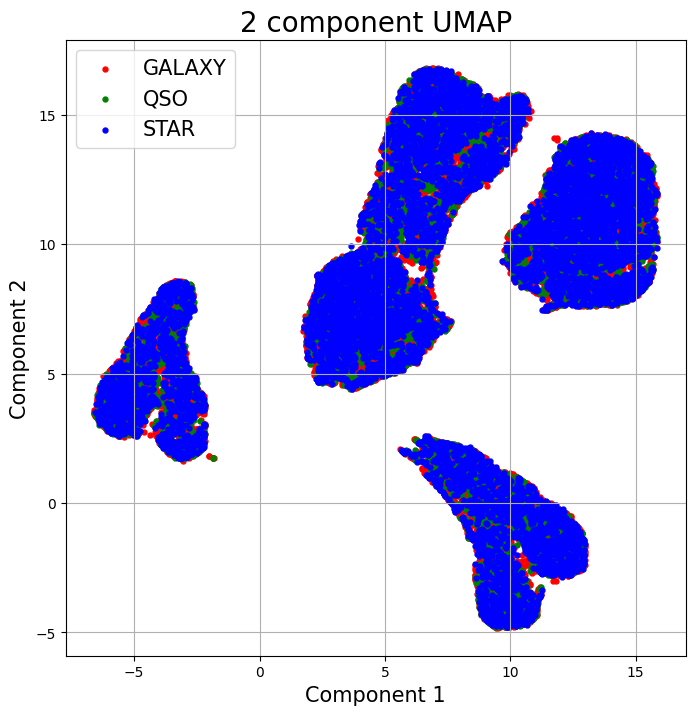

In [40]:
reducer = umap.UMAP()
UmapComponents = reducer.fit_transform(x)
UmapDf = pd.DataFrame(data = UmapComponents,columns = ['component 1', 'component 2'])
finalUmapDf = pd.concat([UmapDf, y_train], axis = 1)
finalUmapDf

visualise_components('UMAP', y_train, finalUmapDf)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 67000 samples in 0.073s...
[t-SNE] Computed neighbors for 67000 samples in 11.886s...
[t-SNE] Computed conditional probabilities for sample 1000 / 67000
[t-SNE] Computed conditional probabilities for sample 2000 / 67000
[t-SNE] Computed conditional probabilities for sample 3000 / 67000
[t-SNE] Computed conditional probabilities for sample 4000 / 67000
[t-SNE] Computed conditional probabilities for sample 5000 / 67000
[t-SNE] Computed conditional probabilities for sample 6000 / 67000
[t-SNE] Computed conditional probabilities for sample 7000 / 67000
[t-SNE] Computed conditional probabilities for sample 8000 / 67000
[t-SNE] Computed conditional probabilities for sample 9000 / 67000
[t-SNE] Computed conditional probabilities for sample 10000 / 67000
[t-SNE] Computed conditional probabilities for sample 11000 / 67000
[t-SNE] Computed conditional probabilities for sample 12000 / 67000
[t-SNE] Computed conditional probabilities for sa

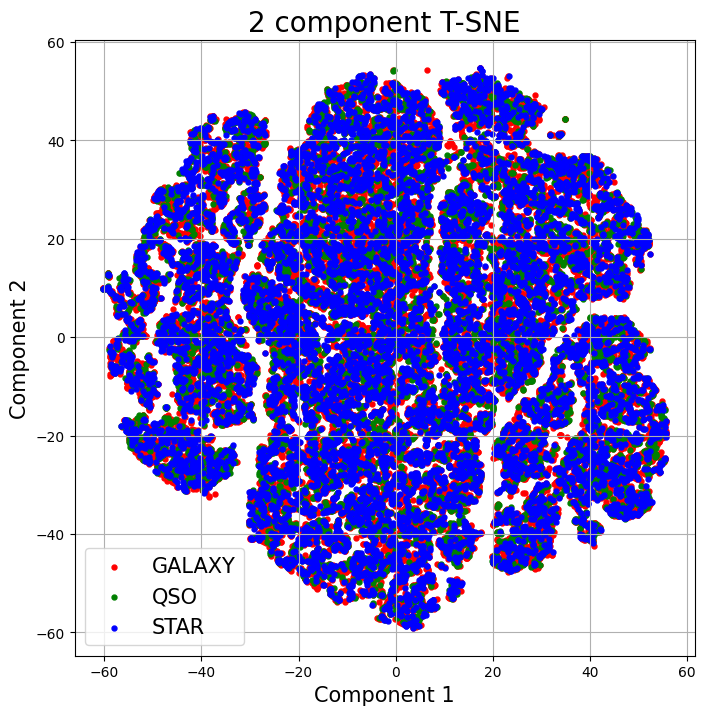

In [41]:
# Use T-SNE to reduce to two dimensions
tsne = TSNE(n_components=2, verbose=1)
tsneComponents = tsne.fit_transform(x)
tsneDf = pd.DataFrame(data = tsneComponents,columns = ['component 1', 'component 2'])
finalTsneDf = pd.concat([tsneDf, y_train], axis = 1)
finalTsneDf

visualise_components('T-SNE', y_train, finalTsneDf)

3


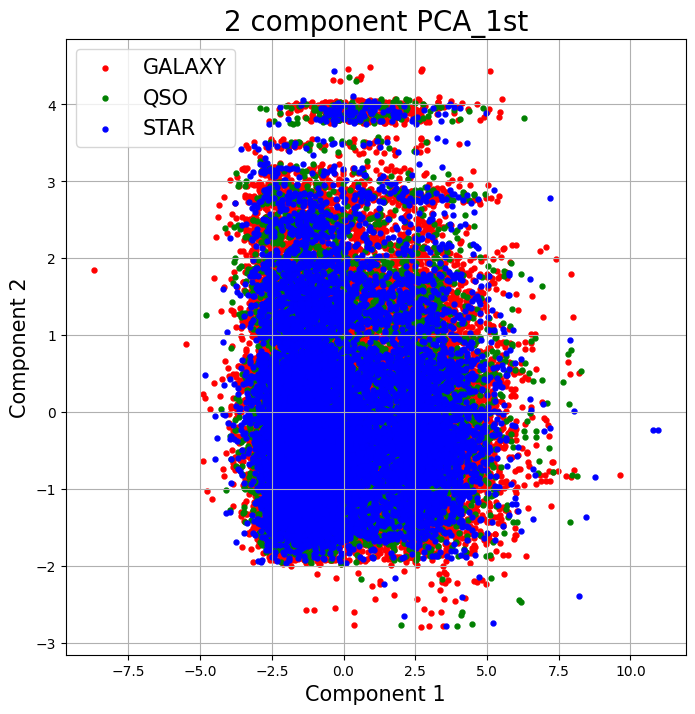

3


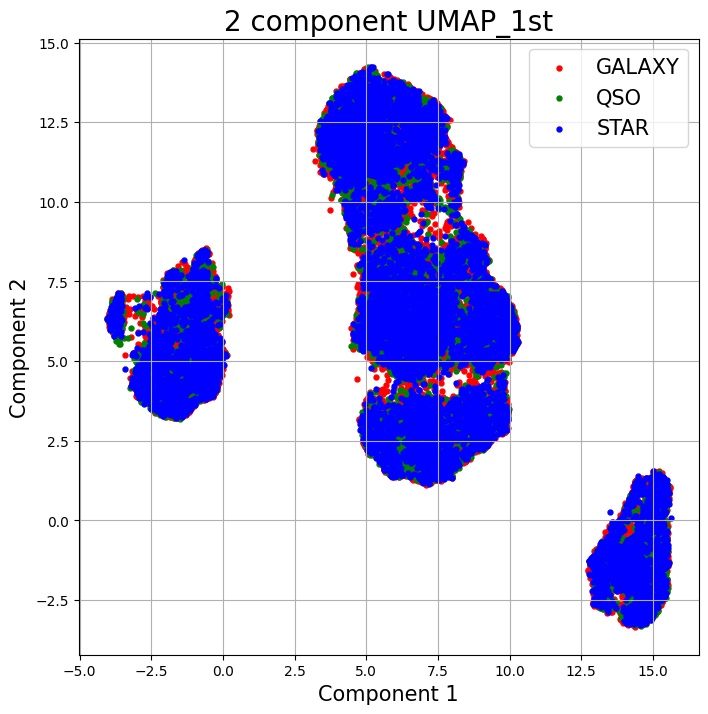

3


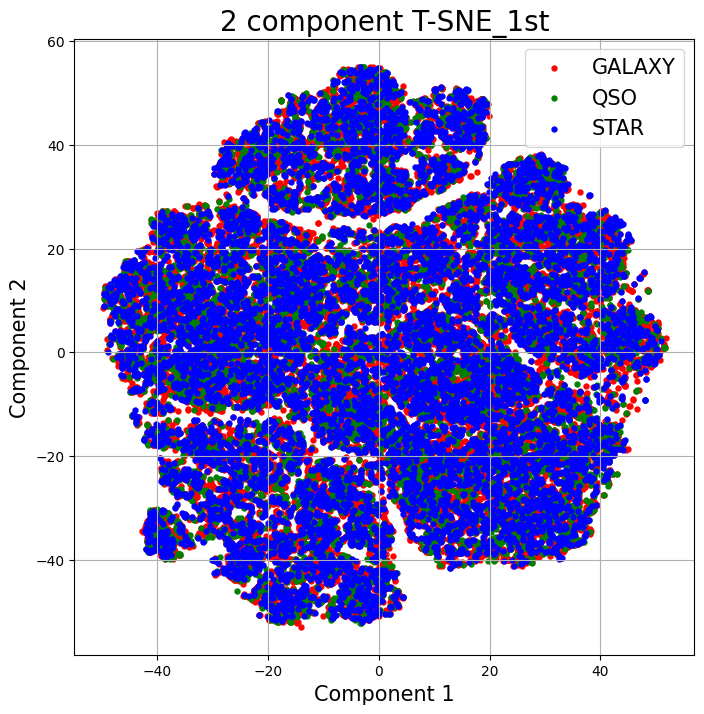

In [33]:
visualise_components('PCA_1st', y_train, finalPca)
visualise_components('UMAP_1st', y_train, finalUmapDf)
visualise_components('T-SNE_1st', y_train, finalTsneDf)